In [125]:
import scipy.io
import numpy as np
import pylops
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import m8r
import matplotlib as mpl
plt.close('all')

In [126]:
# load the data
vel = m8r.Input('vel.rsf')
v1 = vel.int("n1")
v2 = vel.int("n2")
V = vel.read(shape=(v2,v1))

mat = scipy.io.loadmat('GulfOfSuez128.mat')
data = mat["D"]
D = data[:, :, 63]
D_sqz = D.reshape(-1,order = 'C')
nt,nr = D.shape
N = nt*nr
scail = np.sqrt(1./np.prod((nt,nr)))

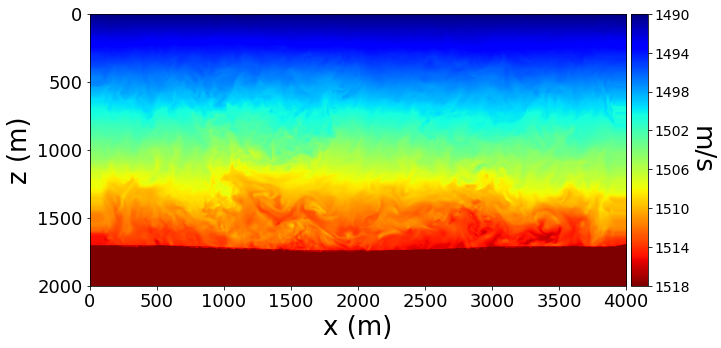

In [146]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(V.T[:801],cmap='jet',aspect='auto',vmin=1490, vmax=1518,extent=[0,4000,2000,0])
ax.set_xlabel('x (m)', fontsize=26)
ax.set_ylabel('z (m)', fontsize=26)
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="1%")
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12) 
cbar.ax.get_yaxis().labelpad = 24
cbar.ax.set_ylabel('m/s', rotation=270, fontsize=26)
cbar.ax.tick_params(labelsize = 14)

cbar.ax.invert_yaxis()
cbar.set_ticks(np.arange(1490, 1519,4))
cbar.set_ticklabels((np.arange(1490, 1519,4)))

plt.show()
fig.savefig('vel.eps', format='eps', dpi=100,bbox_inches='tight')

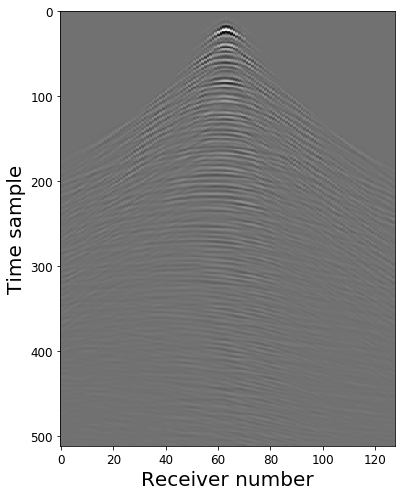

In [3]:
fig, ax = plt.subplots(figsize=(6, 8))
implot = plt.imshow(D,cmap='gray',aspect='auto')
ax.set_xlabel('Receiver number', fontsize=20)
ax.set_ylabel('Time sample', fontsize=20)
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
# plt.colorbar()
plt.show()
# fig.savefig('Ori.eps', format='eps', dpi=300,bbox_inches='tight')


In [4]:
# frqeuncy spectrum
a = 512
b = 128
dt = 4e-3
dx = 10

F = pylops.signalprocessing.FFT2D(dims=(nt,nr),nffts=(nt,nr))

# Here cannot use reshape in column-wise, which is different from that of Matlab
fre = F*D.flatten()

fre = (fre.reshape(nt, nr,order='C')) # undo the scailing
fre_shift = np.fft.fftshift(fre)

fre_np = np.fft.fftshift(np.fft.fft2(D))
fre_np_sqz = fre_np.reshape(-1,order='C')

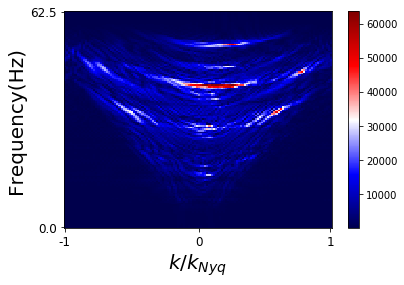

In [5]:
# xaxis = np.fft.fftshift(np.fft.fftfreq(nr,dx))
xaxis = np.array([-1,0,1])
yaxis = np.arange(0,1/(2*dt),1/(dt*nt))

fig, ax = plt.subplots(figsize=(6, 4))
implot = plt.imshow(np.abs(fre_np[127:256,:]),cmap='seismic',aspect='auto')

ax.set_xlabel(r'$k/k_{Nyq}$', fontsize=20)
ax.set_ylabel(r'Frequency(Hz)', fontsize=20)

xticks = np.array([0,64,127])
yticks = np.array([0,128])

ax.set_xticks(xticks)
ax.set_xticklabels(xaxis)
ax.set_yticks(yticks)
ax.set_yticklabels(np.flip(np.take(yaxis, yticks)))

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.colorbar()
plt.show()
# fig.savefig('Ori_fre.eps', format='eps', dpi=300,bbox_inches='tight')

In [6]:
# make Restriction operator in order='C'
idr = np.arange(0,nr,3)
cod = np.arange(0,nt*nr).reshape(nt,nr)
idx = cod[:,idr].flatten()

idr_ir = np.load('Precon_idr.npy')
idx_ir = cod[:,idr_ir].flatten()
R_ir = pylops.Restriction(N, idx_ir)

R = pylops.Restriction(N, idx)
D_dec = R*D_sqz
D_adj = R.H*D_dec

D_dec_ir = R_ir*D_sqz
D_adj_ir = R_ir.H*D_dec_ir


In [7]:
array_1 = np.ones((1,nr))
array_2 = np.zeros((1,nr))
array_3 = np.zeros((1,nr))

array_2[:,idr] = 1
array_3[:,idr_ir] = 1

F_ori = np.abs(np.fft.fftshift(np.fft.fft2(D)))
F_re = np.abs(np.fft.fftshift(np.fft.fft2(D_adj.reshape(nt,nr))))
F_irre = np.abs(np.fft.fftshift(np.fft.fft2(D_adj_ir.reshape(nt,nr))))


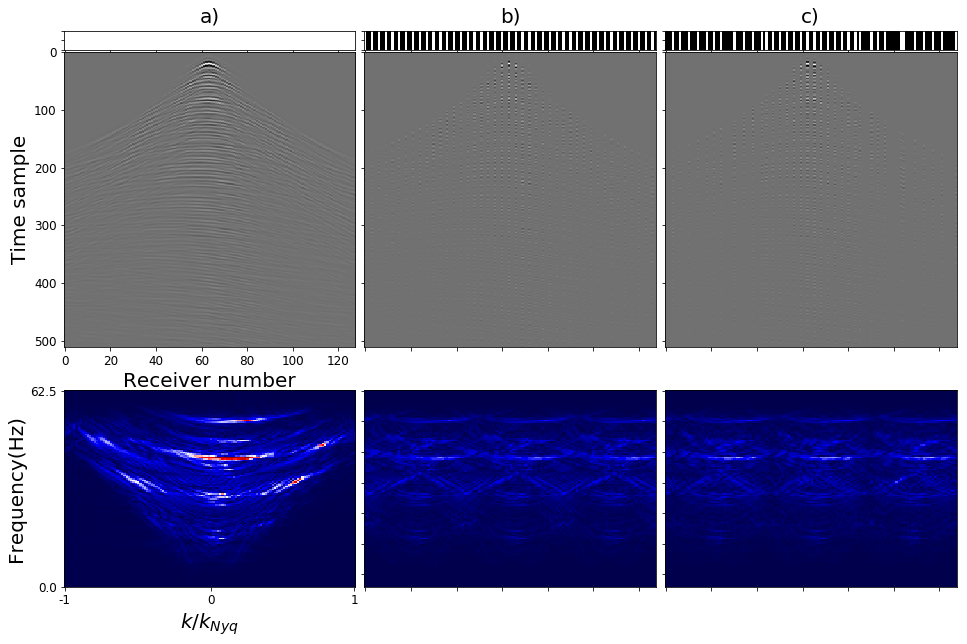

In [8]:
fig = plt.figure(figsize = (16,11))

gs = gridspec.GridSpec(3, 3,height_ratios=[0.1,1.5, 1])
gs.update(wspace=0.03, hspace=0.25)
gs2 = gridspec.GridSpec(3, 3,top=0.827,height_ratios=[0.1,1.5, 1])
gs2.update(wspace=0.03, hspace=0.25)

ax4 = plt.subplot(gs2[0])
ax5 = plt.subplot(gs2[1])
ax6 = plt.subplot(gs2[2])

ax1 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[4])
ax3 = plt.subplot(gs[5])

ax7 = plt.subplot(gs[6])
ax8 = plt.subplot(gs[7])
ax9 = plt.subplot(gs[8])

t_min, t_max = np.amin(D), np.amax(D)
fre_min, fre_max = np.amin(F_ori), np.amax(F_ori)

ax4.imshow(array_1,cmap='gray',aspect='auto',vmin=0,vmax=1)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

ax5.imshow(array_2,cmap='gray',aspect='auto',vmin=0,vmax=1)
ax5.set_xticklabels([])
ax5.set_yticklabels([])

ax6.imshow(array_3,cmap='gray',aspect='auto',vmin=0,vmax=1)
ax6.set_xticklabels([])
ax6.set_yticklabels([])

ax7.imshow(np.abs(F_ori[127:256,:]),cmap='seismic',aspect='auto',
                   vmin=fre_min, vmax = fre_max)
ax7.set_xlabel(r'$k/k_{Nyq}$', fontsize=20)
ax7.set_ylabel(r'Frequency(Hz)', fontsize=20)
ax7.set_xticks(xticks)
ax7.set_xticklabels(xaxis)
ax7.set_yticks(yticks)
ax7.set_yticklabels(np.flip(np.take(yaxis, yticks)))
ax7.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax8.imshow(np.abs(F_re[127:256,:]),cmap='seismic',aspect='auto',
                   vmin=fre_min, vmax = fre_max)
ax8.set_xticklabels([])
ax8.set_yticklabels([])

ax9.imshow(np.abs(F_irre[127:256,:]),cmap='seismic',aspect='auto',
                   vmin=fre_min, vmax = fre_max)
ax9.set_xticklabels([])
ax9.set_yticklabels([])

ax1.imshow(np.real(D),cmap='gray',aspect='auto',vmin=t_min,vmax=t_max)
ax1.set_xlabel('Receiver number', fontsize=20)
ax1.set_ylabel('Time sample', fontsize=20)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax1.set_title('a)',y=1.08,fontsize=20)

ax2.imshow(np.real(D_adj.reshape(nt,nr)),cmap='gray',aspect='auto',vmin=t_min,vmax=t_max)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax2.set_title('b)',y=1.08,fontsize=20)

ax3.imshow(np.real(D_adj_ir.reshape(nt,nr)),cmap='gray',aspect='auto',vmin=t_min,vmax=t_max)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax3.set_title('c)',y=1.08,fontsize=20)

# plt.subplots_adjust(wspace=0.05, hspace=10)
plt.show()
fig.savefig('sampling.eps', format='eps', dpi=100,bbox_inches='tight')

In [10]:
# calculate derivatives from original data(with masks and highpass)
# by hand
fre_sqz = F*D.flatten()
dx=10

ks = np.fft.fftfreq(nr, d=dx)

dt=4e-3
fn=1/(2*dt);

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand = pylops.Diagonal(coeff1_m)
D2op_hand = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand*fre_sqz
D2_hand_fre = D2op_hand*fre_sqz

D1_hand = F.H*D1_hand_fre
D2_hand = F.H*D2_hand_fre


Text(0.5, 1.0, '2nd-order derivative')

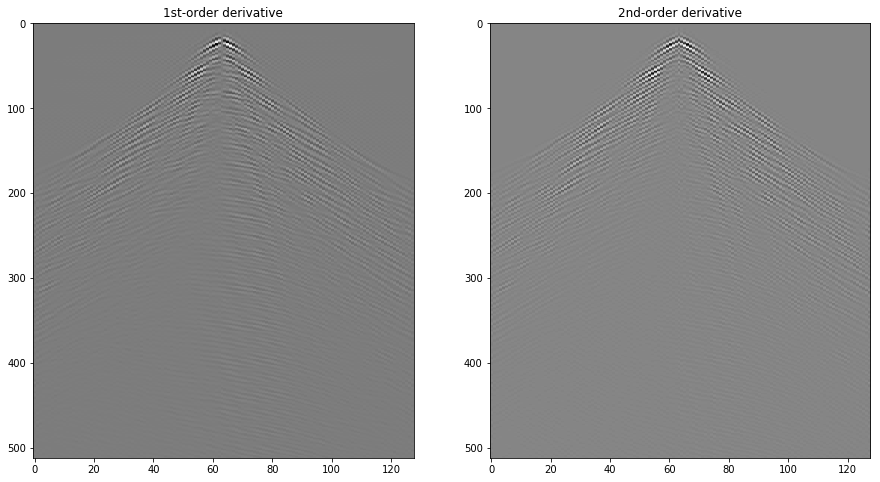

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
axs[0].imshow(np.real(D1_hand.reshape(nt,nr,order='C')),cmap='gray',aspect='auto')
axs[0].set_title('1st-order derivative')
axs[1].imshow(np.real(D2_hand.reshape(nt,nr,order='C')),cmap='gray',aspect='auto')
axs[1].set_title('2nd-order derivative')

In [12]:
# solve the linear equations
# from pylops import sparsity
D2_dec = np.real(R*(D2_hand))
D1_dec = np.real(R*(D1_hand))

# solve in time domain
Forward = R
rhs = D_dec

Forward1 = pylops.VStack([R, R*F.H*D1op_hand*F])
rhs1 = np.concatenate((D_dec, D1_dec))

Forward2 = pylops.VStack([R, R*F.H*D1op_hand*F, R*F.H*D2op_hand*F])
rhs2 = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)

xinv = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward, [], rhs, 
                                                          **dict(damp=0, iter_lim=800, show=1))

xinv1 = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward1, [], rhs1, 
                                                          **dict(damp=0, iter_lim=800, show=1))

xinv2 = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward2, [], rhs2, 
                                                          **dict(damp=0, iter_lim=1400, show=1))


 
LSQR            Least-squares solution of  Ax = b
The matrix A has    22016 rows  and    65536 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      800
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.842e+03  2.842e+03    1.0e+00  3.5e-04
     1  0.00000e+00   0.000e+00  0.000e+00    0.0e+00  0.0e+00   0.0e+00  0.0e+00
 
LSQR finished
Ax - b is small enough, given atol, btol                  
 
istop =       1   r1norm = 0.0e+00   anorm = 0.0e+00   arnorm = 0.0e+00
itn   =       1   r2norm = 0.0e+00   acond = 0.0e+00   xnorm  = 2.8e+03
 
 
LSQR            Least-squares solution of  Ax = b
The matrix A has    44032 rows  and    65536 cols
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =      800
 
   Itn      x[0]       r1norm     r2norm   

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pylops/basicoperators/Restriction.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  y[self.iava] = x
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/sparse/linalg/isolve/lsqr.py:544: ComplexWarning: Casting complex values to real discards the imaginary part
  str1 = '%6g %12.5e' % (itn, x[0])


    31  4.05533e-18   1.149e+02  1.149e+02    4.0e-02  6.4e-08   4.3e+00  1.1e+02
    32  4.05474e-18   1.149e+02  1.149e+02    4.0e-02  7.0e-08   4.4e+00  1.1e+02
    33  4.05528e-18   1.149e+02  1.149e+02    4.0e-02  3.5e-08   4.5e+00  1.2e+02
    34  4.05556e-18   1.149e+02  1.149e+02    4.0e-02  4.1e-08   4.6e+00  1.2e+02
    35  4.05519e-18   1.149e+02  1.149e+02    4.0e-02  2.0e-08   4.7e+00  1.3e+02
    36  4.05490e-18   1.149e+02  1.149e+02    4.0e-02  2.3e-08   4.7e+00  1.3e+02
    37  4.05504e-18   1.149e+02  1.149e+02    4.0e-02  1.1e-08   4.8e+00  1.3e+02
    38  4.05520e-18   1.149e+02  1.149e+02    4.0e-02  1.2e-08   4.9e+00  1.4e+02
    39  4.05511e-18   1.149e+02  1.149e+02    4.0e-02  6.8e-09   5.0e+00  1.4e+02
 
LSQR finished
The least-squares solution is good enough, given atol     
 
istop =       2   r1norm = 1.1e+02   anorm = 5.0e+00   arnorm = 3.9e-06
itn   =      39   r2norm = 1.1e+02   acond = 1.4e+02   xnorm  = 3.5e+03
 
 
LSQR            Least-squares solutio

   878  7.82282e-18   1.295e+02  1.295e+02    4.5e-02  8.2e-08   8.3e+02  5.2e+05
   879  7.82256e-18   1.295e+02  1.295e+02    4.5e-02  8.1e-08   8.3e+02  5.2e+05
   880  7.82231e-18   1.295e+02  1.295e+02    4.5e-02  8.1e-08   8.3e+02  5.2e+05
   881  7.82206e-18   1.295e+02  1.295e+02    4.5e-02  8.1e-08   8.4e+02  5.2e+05
   882  7.82181e-18   1.295e+02  1.295e+02    4.5e-02  8.1e-08   8.4e+02  5.2e+05
   883  7.82156e-18   1.295e+02  1.295e+02    4.5e-02  8.1e-08   8.4e+02  5.3e+05
   884  7.82133e-18   1.295e+02  1.295e+02    4.5e-02  8.0e-08   8.4e+02  5.3e+05
   885  7.82109e-18   1.295e+02  1.295e+02    4.5e-02  8.0e-08   8.4e+02  5.3e+05
   886  7.82086e-18   1.295e+02  1.295e+02    4.5e-02  8.0e-08   8.4e+02  5.3e+05
   887  7.82064e-18   1.295e+02  1.295e+02    4.5e-02  8.0e-08   8.5e+02  5.3e+05
   888  7.82042e-18   1.295e+02  1.295e+02    4.5e-02  8.0e-08   8.5e+02  5.3e+05
   889  7.82020e-18   1.295e+02  1.295e+02    4.5e-02  8.0e-08   8.5e+02  5.3e+05
   890  7.81999e

   978  7.81866e-18   1.295e+02  1.295e+02    4.5e-02  6.5e-08   1.0e+03  6.6e+05
   979  7.81876e-18   1.295e+02  1.295e+02    4.5e-02  6.5e-08   1.0e+03  6.6e+05
   980  7.81886e-18   1.295e+02  1.295e+02    4.5e-02  6.5e-08   1.0e+03  6.6e+05
   981  7.81896e-18   1.295e+02  1.295e+02    4.5e-02  6.5e-08   1.0e+03  6.6e+05
   982  7.81905e-18   1.295e+02  1.295e+02    4.5e-02  6.5e-08   1.0e+03  6.7e+05
   983  7.81915e-18   1.295e+02  1.295e+02    4.5e-02  6.4e-08   1.0e+03  6.7e+05
   984  7.81925e-18   1.295e+02  1.295e+02    4.5e-02  6.4e-08   1.0e+03  6.7e+05
   985  7.81934e-18   1.295e+02  1.295e+02    4.5e-02  6.4e-08   1.0e+03  6.7e+05
   986  7.81944e-18   1.295e+02  1.295e+02    4.5e-02  6.4e-08   1.0e+03  6.7e+05
   987  7.81953e-18   1.295e+02  1.295e+02    4.5e-02  6.4e-08   1.0e+03  6.7e+05
   988  7.81963e-18   1.295e+02  1.295e+02    4.5e-02  6.4e-08   1.0e+03  6.7e+05
   989  7.81972e-18   1.295e+02  1.295e+02    4.5e-02  6.4e-08   1.0e+03  6.8e+05
   990  7.81981e

  1082  7.81863e-18   1.295e+02  1.295e+02    4.5e-02  5.3e-08   1.2e+03  8.2e+05
  1083  7.81849e-18   1.295e+02  1.295e+02    4.5e-02  5.3e-08   1.2e+03  8.2e+05
  1084  7.81835e-18   1.295e+02  1.295e+02    4.5e-02  5.3e-08   1.2e+03  8.3e+05
  1085  7.81821e-18   1.295e+02  1.295e+02    4.5e-02  5.3e-08   1.2e+03  8.3e+05
  1086  7.81806e-18   1.295e+02  1.295e+02    4.5e-02  5.3e-08   1.2e+03  8.3e+05
  1087  7.81792e-18   1.295e+02  1.295e+02    4.5e-02  5.3e-08   1.2e+03  8.3e+05
  1088  7.81777e-18   1.295e+02  1.295e+02    4.5e-02  5.3e-08   1.3e+03  8.3e+05
  1089  7.81761e-18   1.295e+02  1.295e+02    4.5e-02  5.2e-08   1.3e+03  8.3e+05
  1090  7.81746e-18   1.295e+02  1.295e+02    4.5e-02  5.2e-08   1.3e+03  8.4e+05
  1091  7.81731e-18   1.295e+02  1.295e+02    4.5e-02  5.2e-08   1.3e+03  8.4e+05
  1092  7.81715e-18   1.295e+02  1.295e+02    4.5e-02  5.2e-08   1.3e+03  8.4e+05
  1093  7.81699e-18   1.295e+02  1.295e+02    4.5e-02  5.2e-08   1.3e+03  8.4e+05
  1094  7.81683e

  1188  7.79978e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1189  7.79964e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1190  7.79950e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1191  7.79936e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1192  7.79922e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1193  7.79908e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1194  7.79894e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1195  7.79881e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1196  7.79868e-18   1.295e+02  1.295e+02    4.5e-02  4.4e-08   1.5e+03  1.0e+06
  1197  7.79855e-18   1.295e+02  1.295e+02    4.5e-02  4.3e-08   1.5e+03  1.0e+06
  1198  7.79842e-18   1.295e+02  1.295e+02    4.5e-02  4.3e-08   1.5e+03  1.0e+06
  1199  7.79829e-18   1.295e+02  1.295e+02    4.5e-02  4.3e-08   1.5e+03  1.0e+06
  1200  7.79816e

  1290  7.79406e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1291  7.79408e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1292  7.79410e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1293  7.79412e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1294  7.79414e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1295  7.79416e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1296  7.79418e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1297  7.79420e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1298  7.79423e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1299  7.79425e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1300  7.79428e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1301  7.79430e-18   1.295e+02  1.295e+02    4.5e-02  3.7e-08   1.7e+03  1.2e+06
  1302  7.79433e

  1396  7.79679e-18   1.295e+02  1.295e+02    4.5e-02  3.2e-08   2.0e+03  1.4e+06
  1397  7.79679e-18   1.295e+02  1.295e+02    4.5e-02  3.2e-08   2.0e+03  1.4e+06
  1398  7.79679e-18   1.295e+02  1.295e+02    4.5e-02  3.2e-08   2.0e+03  1.4e+06
  1399  7.79679e-18   1.295e+02  1.295e+02    4.5e-02  3.2e-08   2.0e+03  1.4e+06
  1400  7.79679e-18   1.295e+02  1.295e+02    4.5e-02  3.2e-08   2.0e+03  1.4e+06
 
LSQR finished
The iteration limit has been reached                      
 
istop =       7   r1norm = 1.3e+02   anorm = 2.0e+03   arnorm = 8.3e-03
itn   =    1400   r2norm = 1.3e+02   acond = 1.4e+06   xnorm  = 3.6e+03
 


In [13]:
xinv_fre = np.fft.fftshift(np.fft.fft2(np.real(xinv).reshape(nt,nr)))
xinv1_fre = np.fft.fftshift(np.fft.fft2(np.real(xinv1).reshape(nt,nr)))
xinv2_fre = np.fft.fftshift(np.fft.fft2(np.real(xinv2).reshape(nt,nr)))

xinv3 = np.load('Precon_LSQR.npy')
xinv3_fre = np.fft.fftshift(np.fft.fft2(np.real(xinv3).reshape(nt,nr)))

relative_fre = np.abs((xinv_fre - fre_np) / np.amax(fre_np))
relative1_fre = np.abs((xinv1_fre - fre_np) / np.amax(fre_np))
relative2_fre = np.abs((xinv2_fre - fre_np) / np.amax(fre_np))
relative3_fre = np.abs((xinv3_fre - fre_np) / np.amax(fre_np))

combined_data = np.array([relative_fre,relative1_fre,relative2_fre,relative3_fre])
f_min, f_max = np.amin(combined_data), np.amax(combined_data)

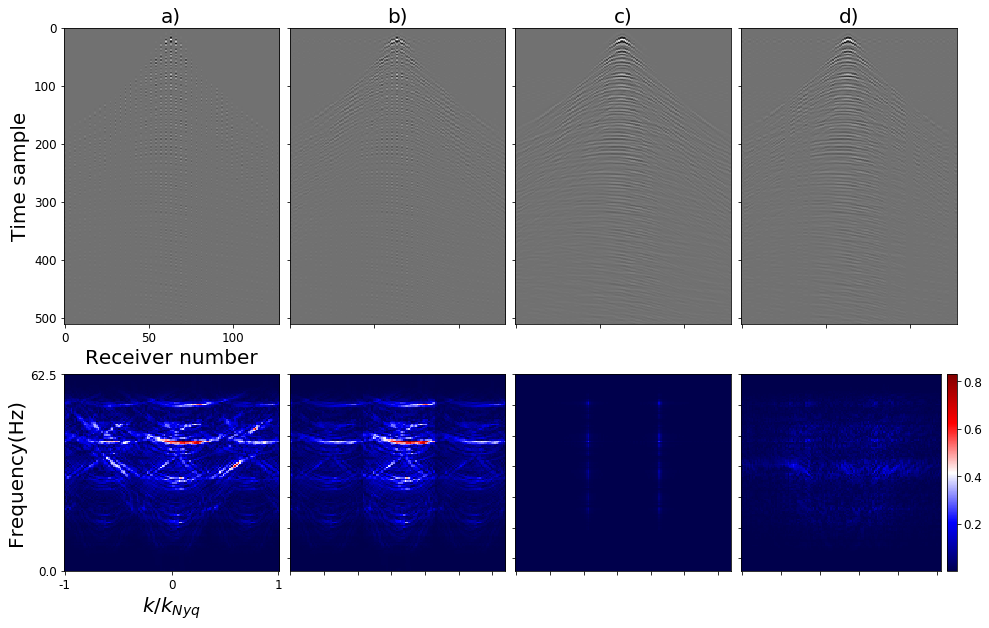

In [14]:
fig = plt.figure(figsize = (16,10))
gs = gridspec.GridSpec(2, 4,
                       height_ratios=[1.5, 1]
                       )
gs.update(wspace=0.05, hspace=0.20)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])
ax6 = plt.subplot(gs[6])

ax7 = plt.subplot(gs[3])
ax8 = plt.subplot(gs[7])
ax1.imshow(np.real(xinv.reshape(nt,nr)),cmap='gray',aspect='auto',vmin=t_min,vmax=t_max)
ax1.set_xlabel('Receiver number', fontsize=20)
ax1.set_ylabel('Time sample', fontsize=20)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax1.set_title('a)',y=1,fontsize=20)

ax2.imshow(np.real(xinv1.reshape(nt,nr)),cmap='gray',aspect='auto',vmin=t_min,vmax=t_max)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax2.set_title('b)',y=1,fontsize=20)

ax3.imshow(np.real(xinv2.reshape(nt,nr)),cmap='gray',aspect='auto',vmin=t_min,vmax=t_max)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax3.set_title('c)',y=1,fontsize=20)

ax7.imshow(np.real(xinv3.reshape(nt,nr)),cmap='gray',aspect='auto',vmin=t_min,vmax=t_max)
ax7.set_xticklabels([])
ax7.set_yticklabels([])
ax7.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax7.set_title('d)',y=1,fontsize=20)

ax4.imshow(np.abs(relative_fre[127:256,:]),cmap='seismic',aspect='auto',
                   vmin=f_min, vmax = f_max)
ax4.set_xlabel(r'$k/k_{Nyq}$', fontsize=20)
ax4.set_ylabel(r'Frequency(Hz)', fontsize=20)
ax4.set_xticks(xticks)
ax4.set_xticklabels(xaxis)
ax4.set_yticks(yticks)
ax4.set_yticklabels(np.flip(np.take(yaxis, yticks)))
ax4.tick_params(axis = 'both', which = 'major', labelsize = 12)
# plt.colorbar()

ax5.imshow(np.abs(relative1_fre[127:256,:]),cmap='seismic',aspect='auto',
                   vmin=f_min, vmax = f_max)

ax5.set_xticklabels([])
ax5.set_yticklabels([])
# plt.colorbar()

im = ax6.imshow(np.abs(relative2_fre[127:256,:]),cmap='seismic',aspect='auto',
                   vmin=f_min, vmax = f_max)

ax6.set_xticklabels([])
ax6.set_yticklabels([])
# plt.colorbar()

im = ax8.imshow(np.abs(relative3_fre[127:256,:]),cmap='seismic',aspect='auto',
                   vmin=f_min, vmax = f_max)

ax8.set_xticklabels([])
ax8.set_yticklabels([])

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(im, cax=cax)
cbar.ax.tick_params(labelsize=12) 


plt.subplots_adjust(wspace=0.05, hspace=0.2)

# plt.tight_layout()
plt.show()
fig.savefig('Plot.eps', format='eps', dpi=100,bbox_inches='tight')

